In [1]:
import NotebookImport
import DX_screen as DX

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../DX/Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [3]:
from Imports import *
from Preprocessing.ClinicalDataFilters import *

importing IPython notebook from Preprocessing/ClinicalDataFilters

importing IPython notebook from Preprocessing/ClinicalData

PCPG
UCS
MESO


In [4]:
def plot_HR(ci, colors=None, ax=None):
    _, ax = init_ax(ax)
    if colors is None:
        colors = ['grey'] * ci.shape[0]
    ci = np.log2(ci)
    for i,(h,v) in enumerate(ci.iterrows()):
        ax.scatter(v['exp(coef)'], i, marker='s', s=100, color=colors[i], 
                   edgecolors=['black'], zorder=10)
        ax.plot((v['lower .95'],v['upper .95']), (i,i), 
                    lw=3, ls='-', marker='o', dash_joinstyle='bevel', 
                color=colors[i])
    prettify_ax(ax)
    ax.set_ybound(-.5, i + .5)
    ax.set_yticks(range(i+1))
    ax.set_yticklabels(ci.index)
    ax.axvline(0, ls='--', lw=2, color='grey', zorder=-1)
    ax.set_xticklabels(2.**ax.get_xticks())

In [5]:
fm = DX.dx_rna.frac
fm.shape

(18419,)

In [6]:
rna_df = DX.rna_df
pts = [p for p in rna_df.columns.get_level_values(0) if 
       (p,'01') in rna_df.columns and (p,'11') in rna_df.columns]
pts = list(set(pts))
len(pts)

650

In [7]:
mm = rna_df.xs('11',1,1).ix[:, pts].mean(1).ix[fm.index]
ss = rna_df.xs('11',1,1).ix[:, pts].std(1).ix[fm.index]

In [8]:
store = pd.HDFStore('/data_ssd/RNASeq_2015_02_04.h5')
rna_s = {}
for c in store.keys():
    if c in ['/matched_tn','/codes']:
        continue
    df = store[c].ix[fm.index]
    tissue = pd.value_counts(df.columns.get_level_values(1)).index[0]
    df = df.sub(mm, axis=0).div(ss, axis=0)
    rna_s[c] = df.corrwith(fm - .5)
rna_s = pd.concat(rna_s)
rna_s.index = rna_s.index.droplevel(0)
rna_s = rna_s.groupby(level=[0,1]).first()
rp = rna_s.dropna()

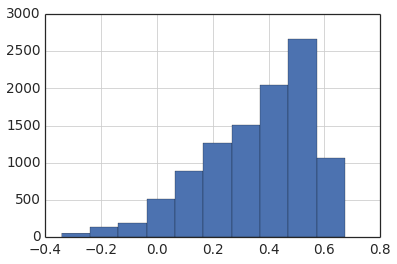

In [9]:
rp.hist()

In [10]:
mm = rna_df.xs('11',1,1).ix[:, pts].mean(1).ix[fm.index]
ss = rna_df.xs('11',1,1).ix[:, pts].std(1).ix[fm.index]
df = store[c].ix[fm.index]
tissue = pd.value_counts(df.columns.get_level_values(1)).index[0]
df = df.sub(mm, axis=0).div(ss, axis=0)

In [21]:
plt.rcParams['savefig.dpi'] = 300

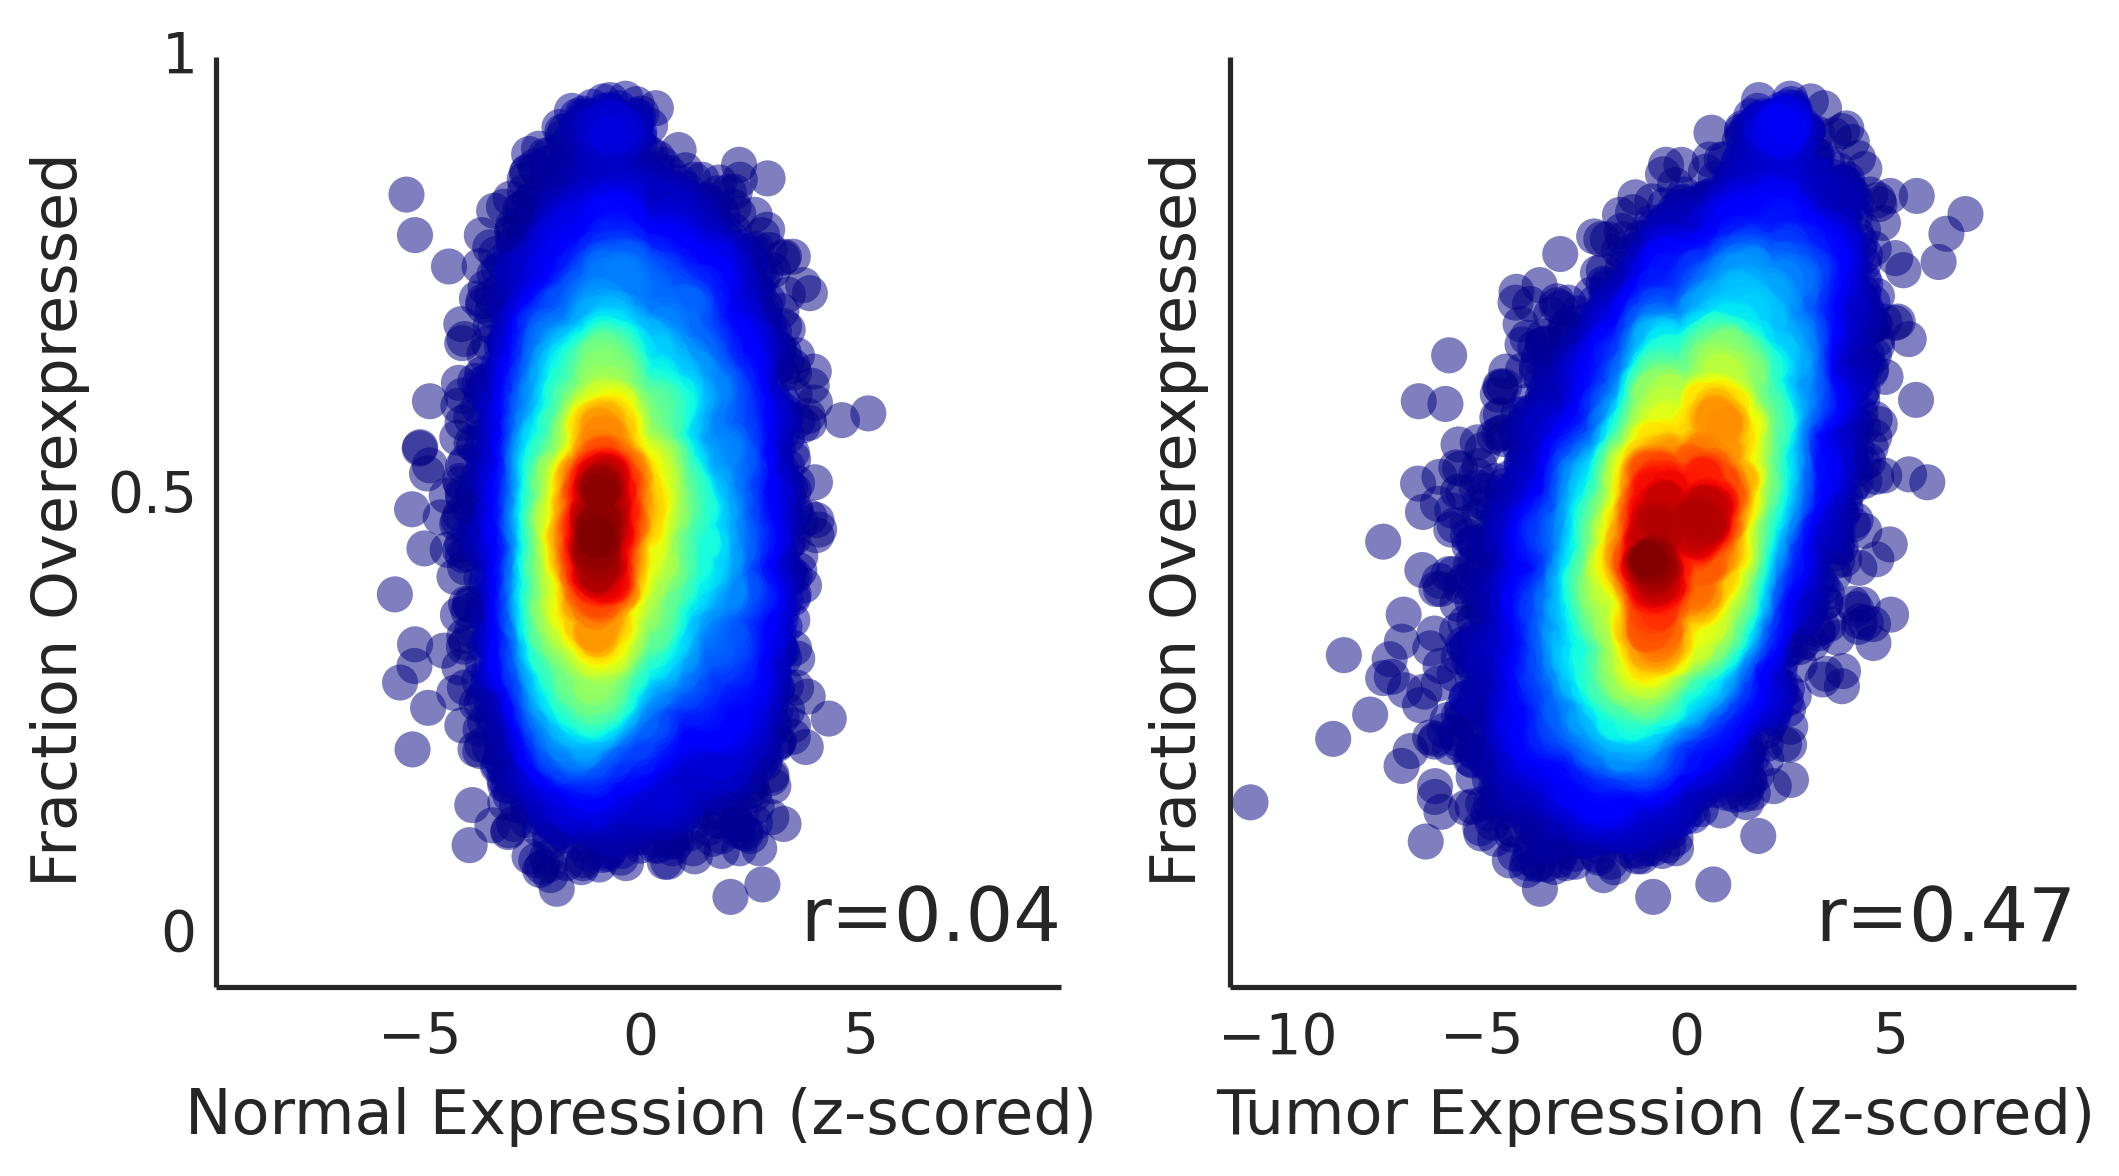

In [27]:
fig, axs = subplots(1,2, figsize=(8,4), sharey=True)
v = df.ix[:, 'TCGA-W5-AA2I']['11']
plot_regression(v, (fm * 20) - 10, density=True, rad=.5,
               line_args={'lw': 0}, ax=axs[0], rasterized=True)
axs[0].set_xlabel('Normal Expression (z-scored)')
v = df.ix[:, 'TCGA-W5-AA2I']['01']
plot_regression(v, (fm * 20) - 10, density=True, rad=.5,
                line_args={'lw': 0}, ax=axs[1], rasterized=True)
axs[1].set_xlabel('Tumor Expression (z-scored)')


for ax in axs:
    ax.set_yticks([-10,0,10])
    ax.set_yticklabels([0,.5,1])
    ann = ax.get_children()[4]
    ann.set_text(ann.get_text().split()[0])
    ax.set_ylabel('Fraction Overexpressed')

In [29]:
fig.savefig('/cellar/users/agross/figures/dx_example.pdf')

In [30]:
mm = rp.unstack()[['01','11']].dropna().stack()
((mm[:, '01'] - mm[:, '11']) > 0).value_counts()

True     659
False     10
dtype: int64

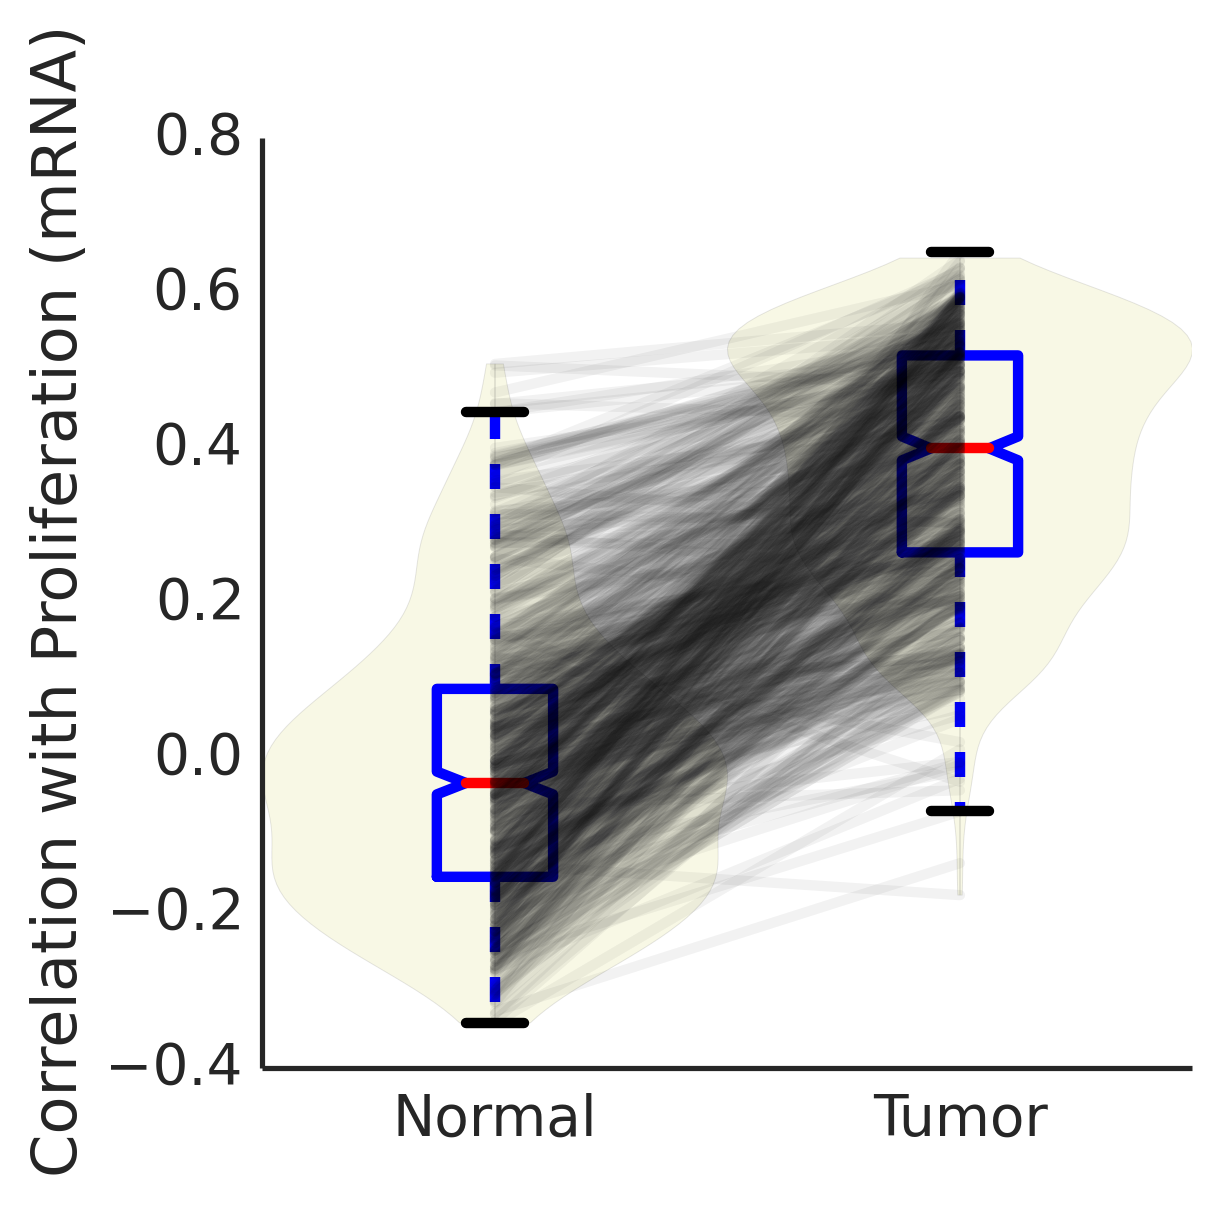

In [31]:
mm = rp.unstack()[['01','11']].dropna().stack()
fig, ax = subplots(figsize=(4,4))
violin_plot_series(mm, ax=ax, order=['11','01'], ann=None)

for i,v in mm.unstack().iterrows():
    ax.plot([0,1],[v['11'], v['01']], color='black', alpha=.05)
ax.set_ylabel('Correlation with Proliferation (mRNA)')
ax.set_xlabel('')
ax.set_xticklabels(['Normal','Tumor'])
prettify_ax(ax)

In [32]:
fig.savefig('/cellar/users/agross/figures/dx_paired.pdf')

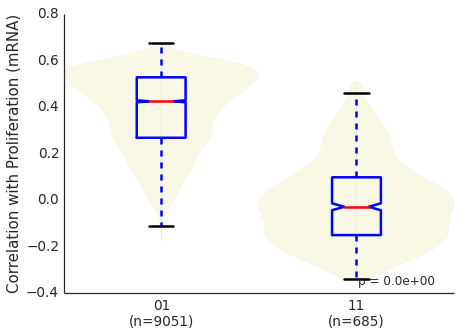

In [15]:
fig, ax = subplots(figsize=(7,5))
violin_plot_series(rp, ax=ax, order=['01','11'])
ax.set_ylabel('Correlation with Proliferation (mRNA)')
ax.set_xlabel('')
prettify_ax(ax)

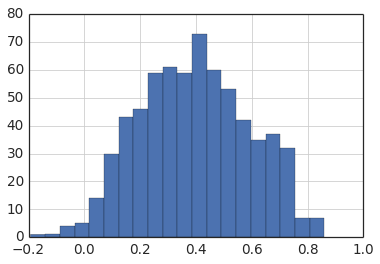

In [12]:
(rp[:, '01'] - rp[:, '11']).hist(bins=20)

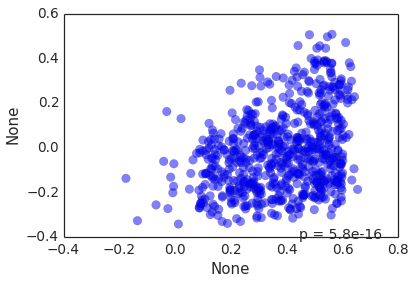

In [70]:
series_scatter(rp[:, '01'], rp[:, '11'])

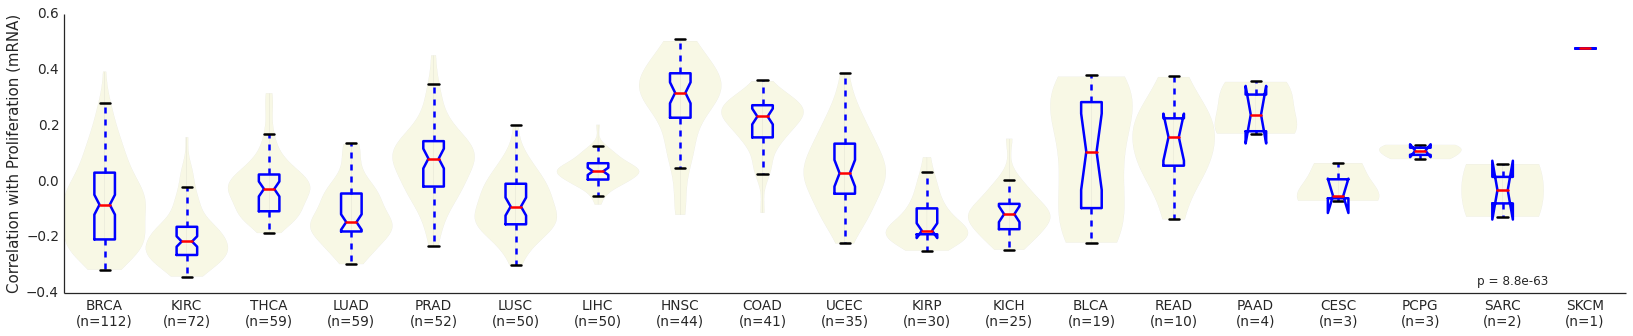

In [16]:
fig, ax = subplots(figsize=(28,5))
violin_plot_pandas(DX.codes, rp[:,'11'], ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Correlation with Proliferation (mRNA)')
prettify_ax(ax)

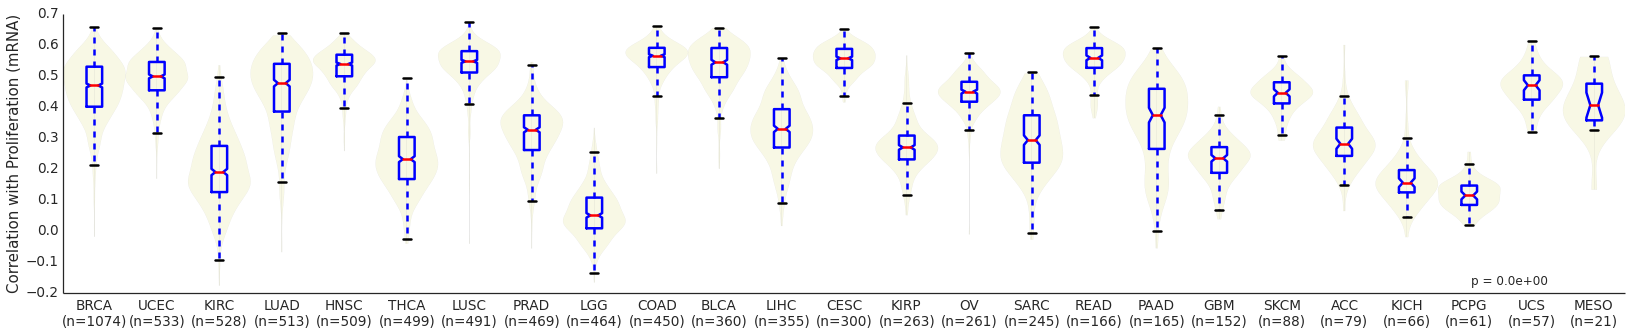

In [27]:
fig, ax = subplots(figsize=(28,5))
violin_plot_pandas(codes, rp[:,'01'], ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Correlation with Proliferation (mRNA)')
prettify_ax(ax)

In [33]:
from Figures.Boxplots import _violin_plot

In [34]:
import seaborn as sns

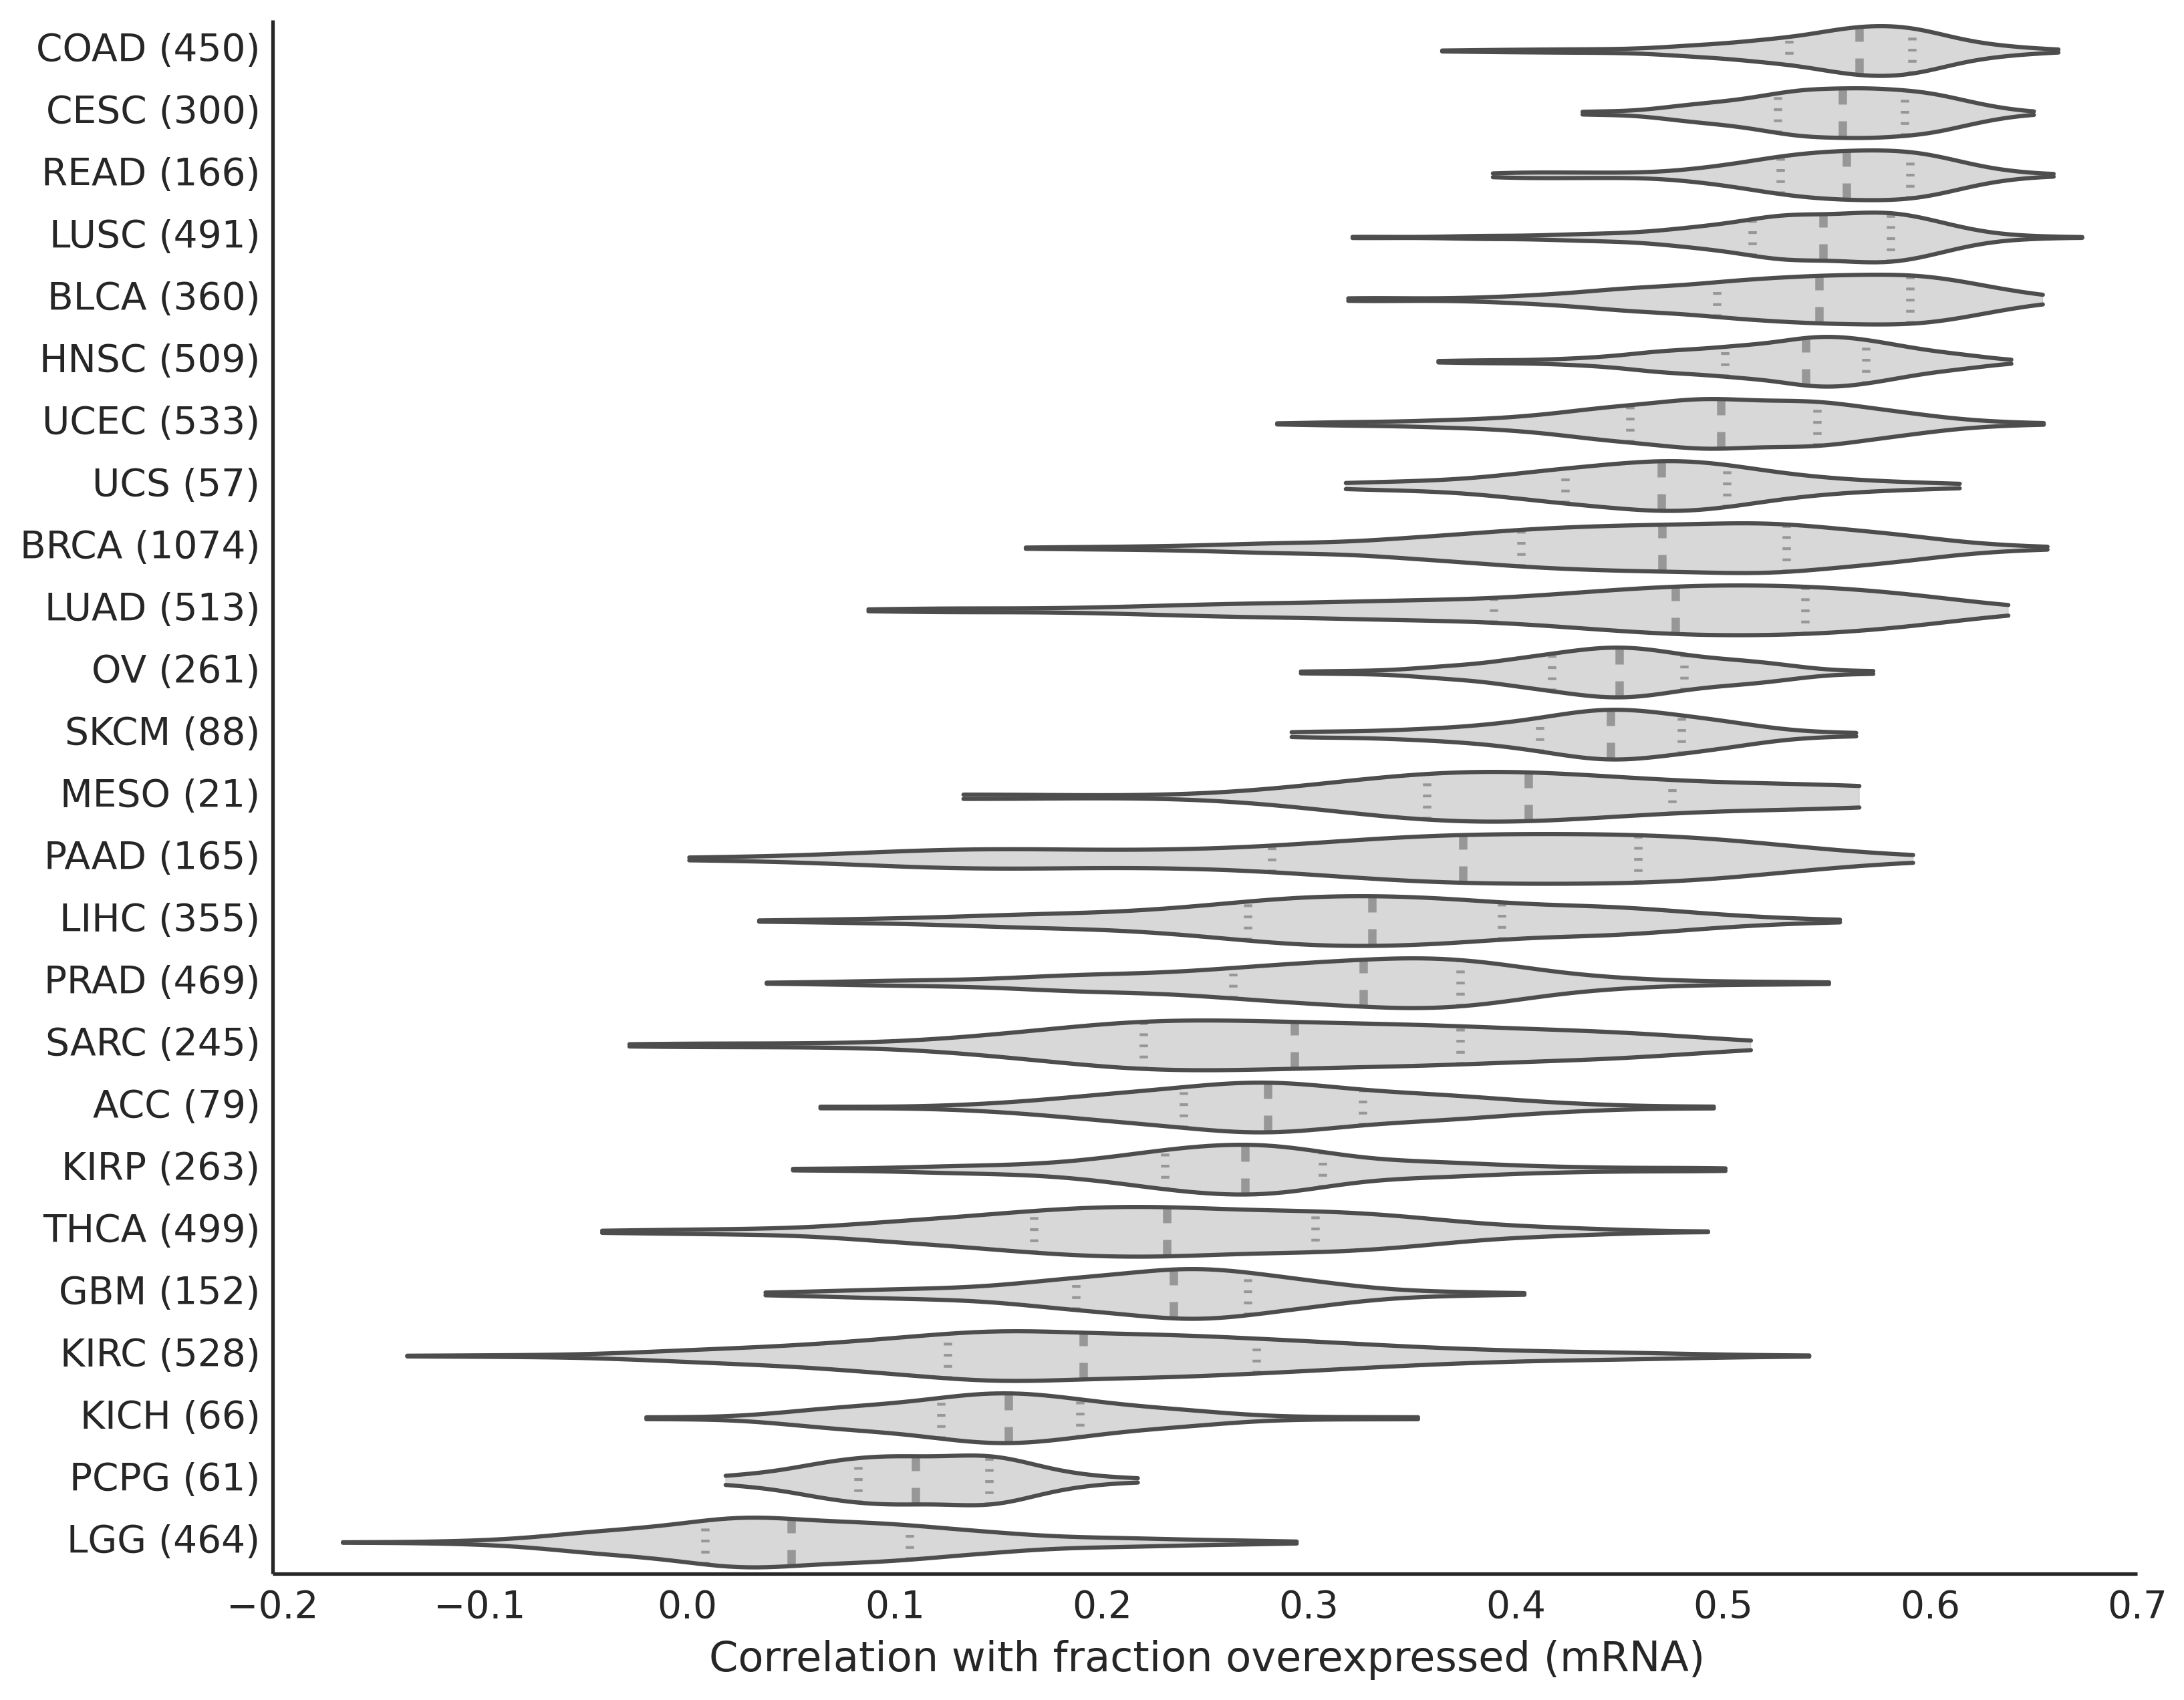

In [36]:
fig, ax = subplots(figsize=(12,10))
zscore = lambda s: (s - s.mean()) / s.std()
vv= rp[:,'01']
z = vv.groupby(codes).apply(zscore)
v2 = vv[z.abs() < 3]
o = v2.groupby(codes).mean().order().index
labels = vv.groupby(codes).size().ix[o]
labels = ['{} ({})'.format(i,v) for i,v in labels.iteritems()]
sns.violinplot(v2, groupby=codes, vert=False,
               bw='scott', cut=0, 
               order=o,
               color='grey', alpha=.3,
               inner_kws={'lw':3, 'alpha':1,'color':'black'},
               names=labels)
ax.set_xlabel('Correlation with fraction overexpressed (mRNA)')
sns.despine(fig)

In [37]:
fig.savefig('/cellar/users/agross/figures/fox_by_cancer.pdf')

In [39]:
f = rp[:, '01'].copy()
f = (f - f.mean()) / f.std()
m = get_cox_ph(surv_5y, f, [codes, stage, old, age], print_desc=False, interactions=False)
ci = convert_robj(robjects.r.summary(m)[7])
ci.index = ci.index.map(lambda s: s.replace('codes', ''))
ci.index = ci.index.map(lambda s: s.replace('stagestage', 'stage'))
pancan_ci = ci.ix['feature']
pancan_ci.name = 'PANCAN'

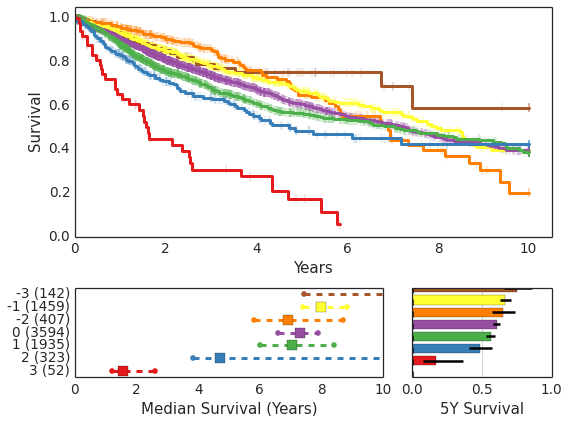

In [241]:
v = rp.ix[:, '01'].dropna()
v = v - codes.map(v.groupby(codes).median())
survival_and_stats(np.round((v - v.mean()) / v.std()).clip(-3,3), surv_10y,
                   figsize=(8,6), upper_lim=10)

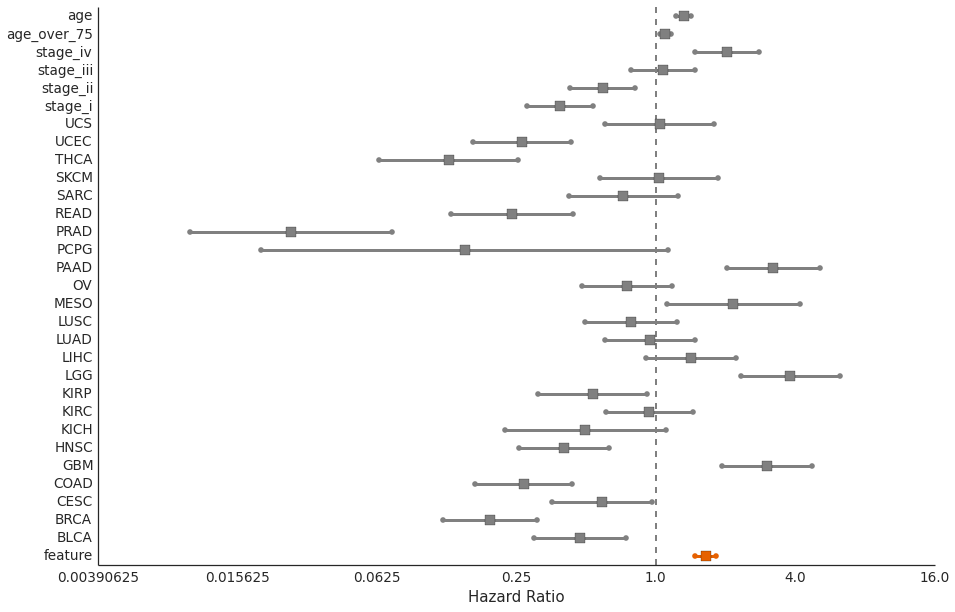

In [104]:
fig, ax = subplots(figsize=(15,10))
colors= ['#E66101'] + (['grey'] * (ci.shape[0] - 1))
plot_HR(ci, ax=ax, colors=colors)
ax.set_xlabel('Hazard Ratio')

#### Here I'm leaving out stage as an optimistic estimate

In [40]:
v = rp[:, '01'].dropna()
ci = {}
for c in codes.unique():
    try:
        pts = ti(codes == c)
        f = v.ix[pts].dropna()
        cov = [b.ix[pts].dropna() for b in [old, age] if 
               b.ix[pts].dropna().unique().shape[0] > 1]
        f = (f - f.mean()) / f.std()
        f.name = 'featue'
        ff = ' + '.join(['feature'] + [b.name for b in cov])
        formula = robjects.Formula('Surv(days, event) ~ ' + ff)
        m1 = get_cox_ph(surv_5y, f, covariates=cov, formula=formula,
                        print_desc=False, interactions=False);
        ci[c] = convert_robj(robjects.r.summary(m1)[7])
    except:
        print c
cc = pd.concat(ci).xs('feature', level=1)
cc = cc.sort('exp(coef)', ascending=False)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 4]

ESCA
STAD


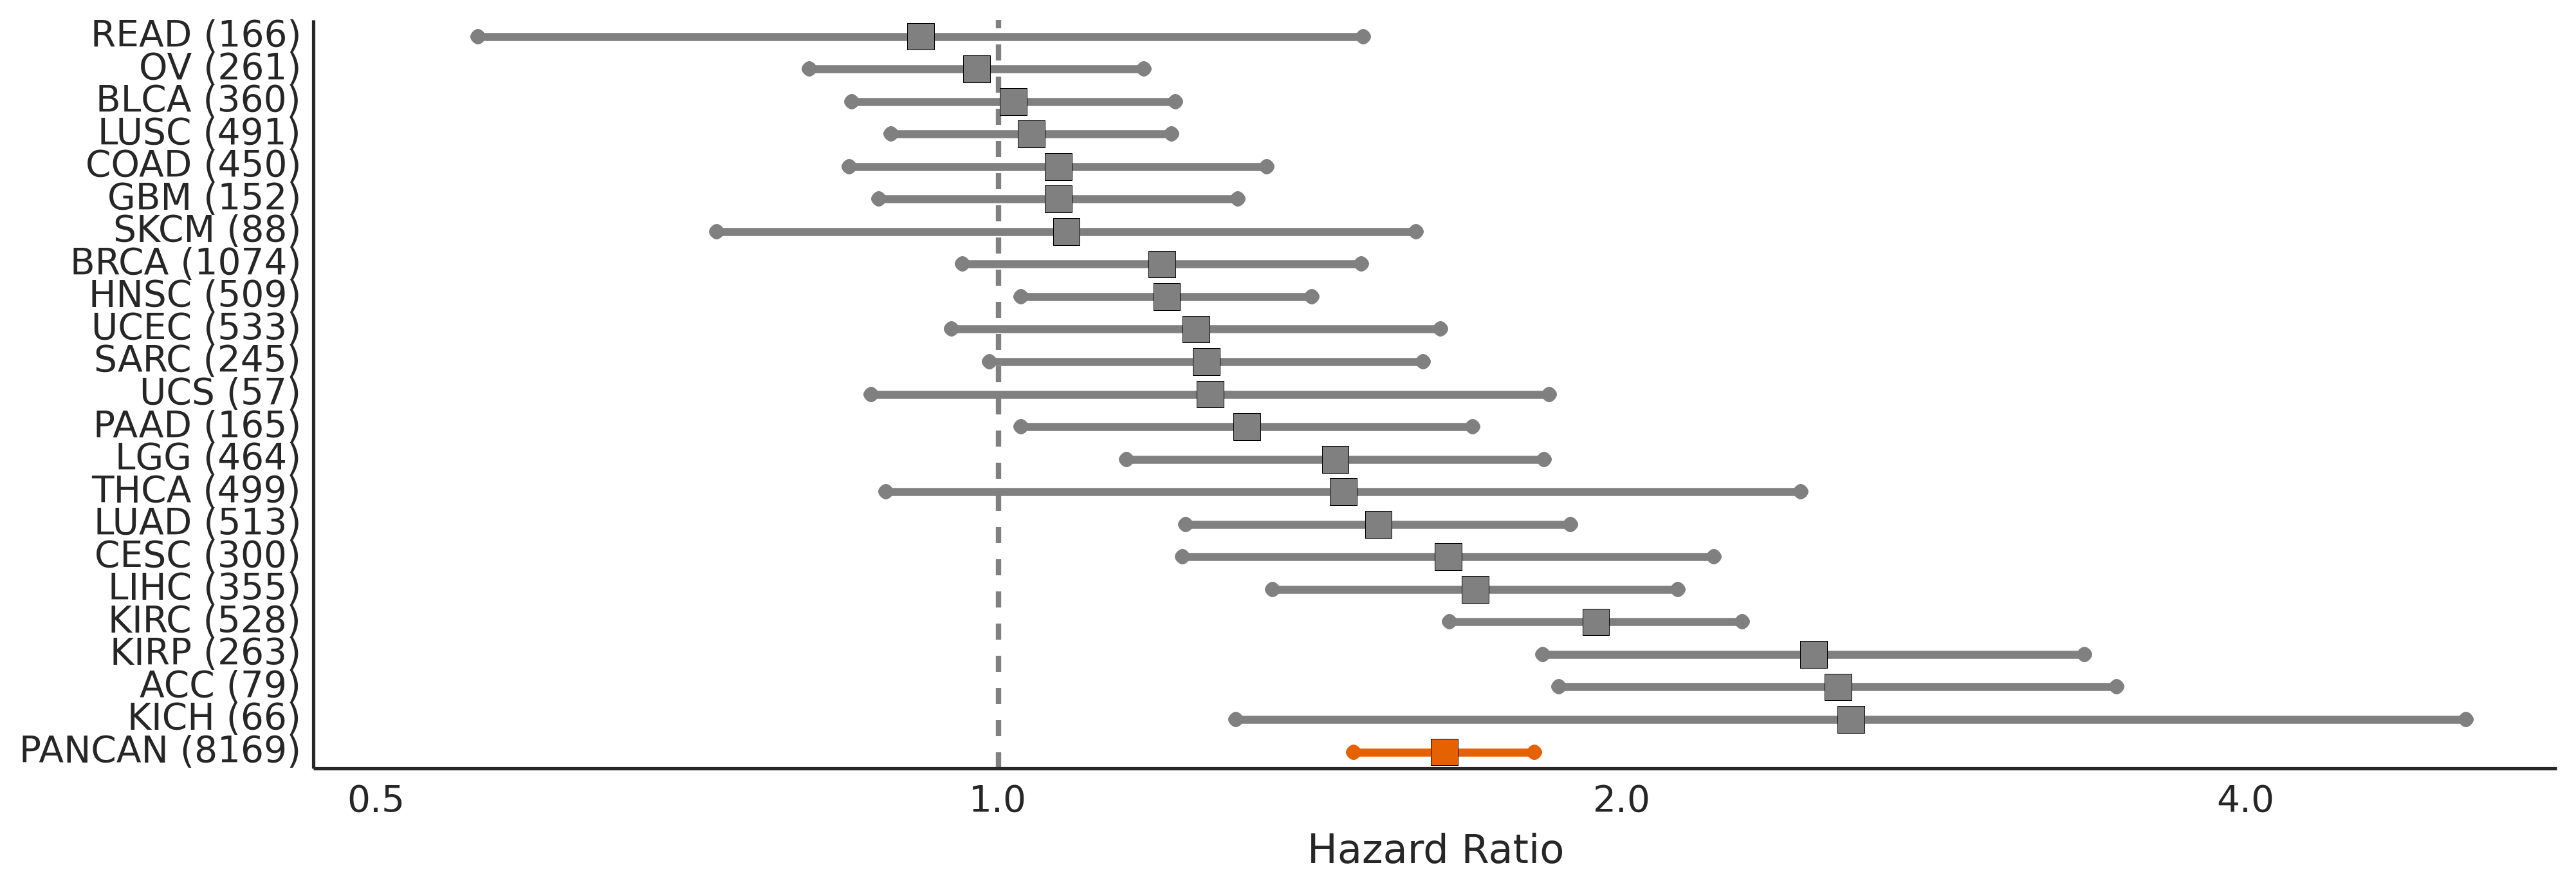

In [41]:
fig, ax = subplots(figsize=(15,5))
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2, ax=ax, colors=colors)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
codes_f = codes.ix[(codes.index.intersection(v.index).intersection(stage.index).
                    intersection(age.index).intersection(old.index))]
label = ['{} ({})'.format(i,c) for i,c in 
         codes_f.value_counts().ix[cc.index].iteritems()]
label = ['PANCAN ({})'.format(len(codes_f))] + label
ax.set_yticklabels(label);
ax.set_xlabel('Hazard Ratio')

In [205]:
surv_5y.ix[ti(codes=='PCPG')].unstack().sum()

days     37646
event        1
dtype: float64

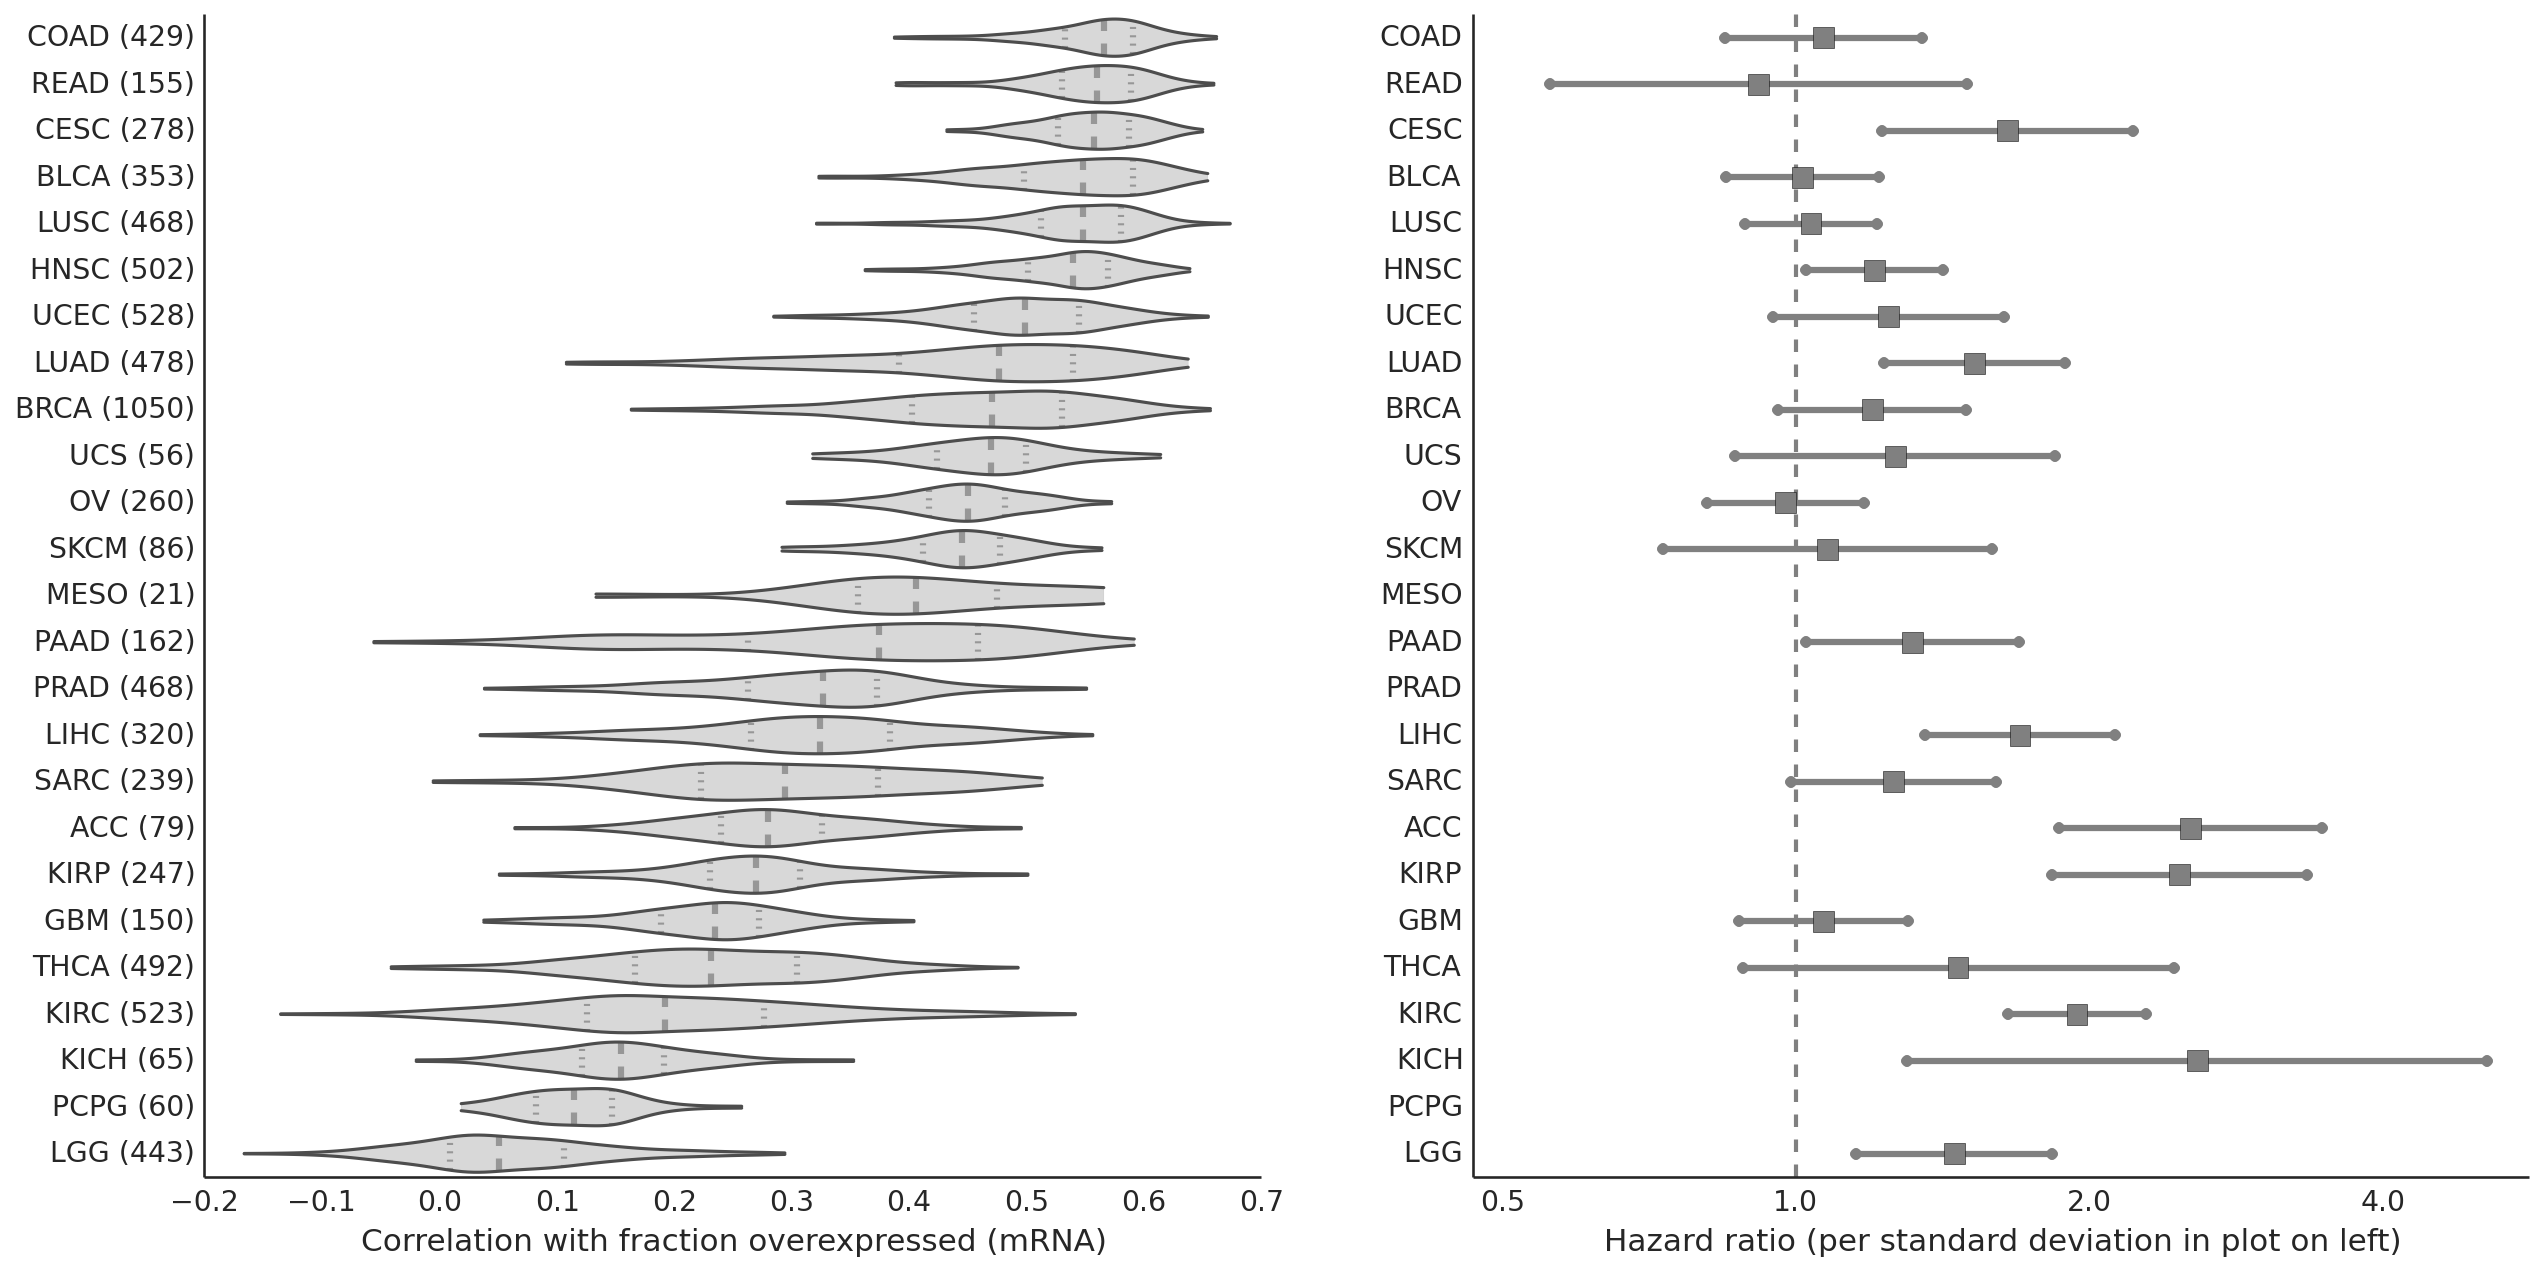

In [69]:
fig, axs = subplots(1, 2, figsize=(20,10))
ax = axs[0]
zscore = lambda s: (s - s.mean()) / s.std()
vv= rp[:,'01'].ix[surv_5y.unstack().index].dropna()
z = vv.groupby(codes).apply(zscore)
v2 = vv[z.abs() < 3]
o = v2.groupby(codes).median().order().index
labels = vv.groupby(codes).size().ix[o]
labels = ['{} ({})'.format(i,v) for i,v in labels.iteritems()]
sns.violinplot(v2, groupby=codes, vert=False,
               bw='scott', cut=0, 
               order=o,
               color='grey', alpha=.3,
               inner_kws={'lw':3, 'alpha':1,'color':'black'},
               names=labels,
               ax=axs[0])
ax.set_xlabel('Correlation with fraction overexpressed (mRNA)')

ax = axs[1]
c2 = pd.DataFrame([pancan_ci]).append(cc)
colors = ['#E66101'] + (['grey'] * len(cc))
plot_HR(c2.ix[o], ax=ax)
ax.set_xlim(-1.1, 2.5)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels(2.**ax.get_xticks())
ax.set_xlabel('Hazard ratio (per standard deviation in plot on left)')

sns.despine(fig)

In [70]:
fig.savefig('/cellar/users/agross/figures/dx_c.pdf')

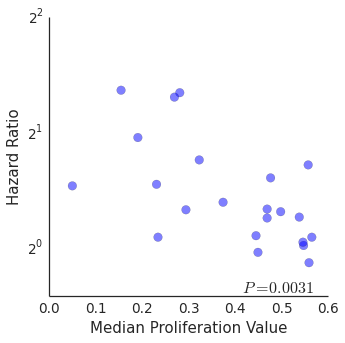

In [234]:
fig, ax = subplots(figsize=(5,5))
cc = pd.concat(ci).xs('feature', level=1)
cc = cc[(cc['upper .95'] - cc['lower .95']) < 4]
v = rp[:,'01'].ix[surv_5y.unstack().index].dropna()
series_scatter(v.groupby(codes).median(), cc['exp(coef)'],
              ax=ax, ann='fancy_p')
prettify_ax(ax)
ax.set_yscale('log', basey=2)
ax.set_ylim(.75,4.)
ax.set_xlabel('Median Proliferation Value')
ax.set_ylabel('Hazard Ratio')

In [198]:
get_cox_ph_ms(surv, v, c.clinical.mitosescount.dropna()>20, interactions=False)

LR                                                0.00203
feature_p                                        0.000228
fmla         Surv(days, event) ~ feature + mitosescount\n
hazzard                                          1.93e+04
dtype: object

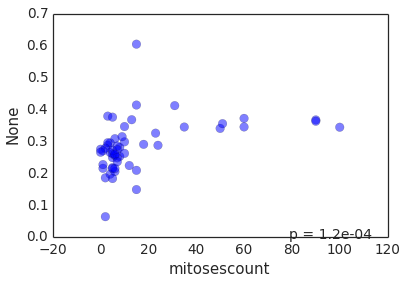

In [186]:
series_scatter(c.clinical.mitosescount, v)

In [61]:
plt.rcParams['savefig.dpi'] = 150

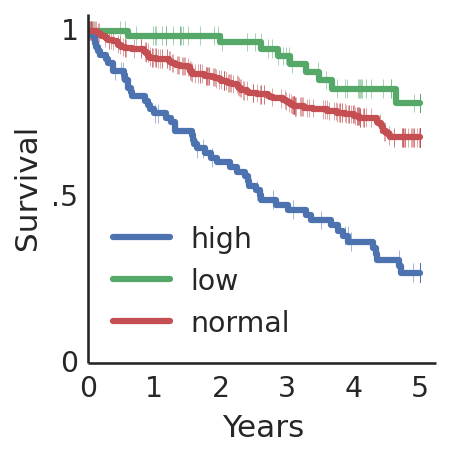

In [72]:
fig, ax = subplots(figsize=(3,3))
v = rp[:, '01'].dropna()
draw_survival_curve(to_quants(v.ix[ti(codes=='KIRC')].dropna(), 
                               std=1, labels=True),
                     surv_5y, ax=ax)
ax.set_yticks([0,.5,1])
ax.set_yticklabels(['0','.5','1'])
sns.despine(fig)
fig.savefig('/cellar/users/agross/figures/surv.pdf',trasparent=True)

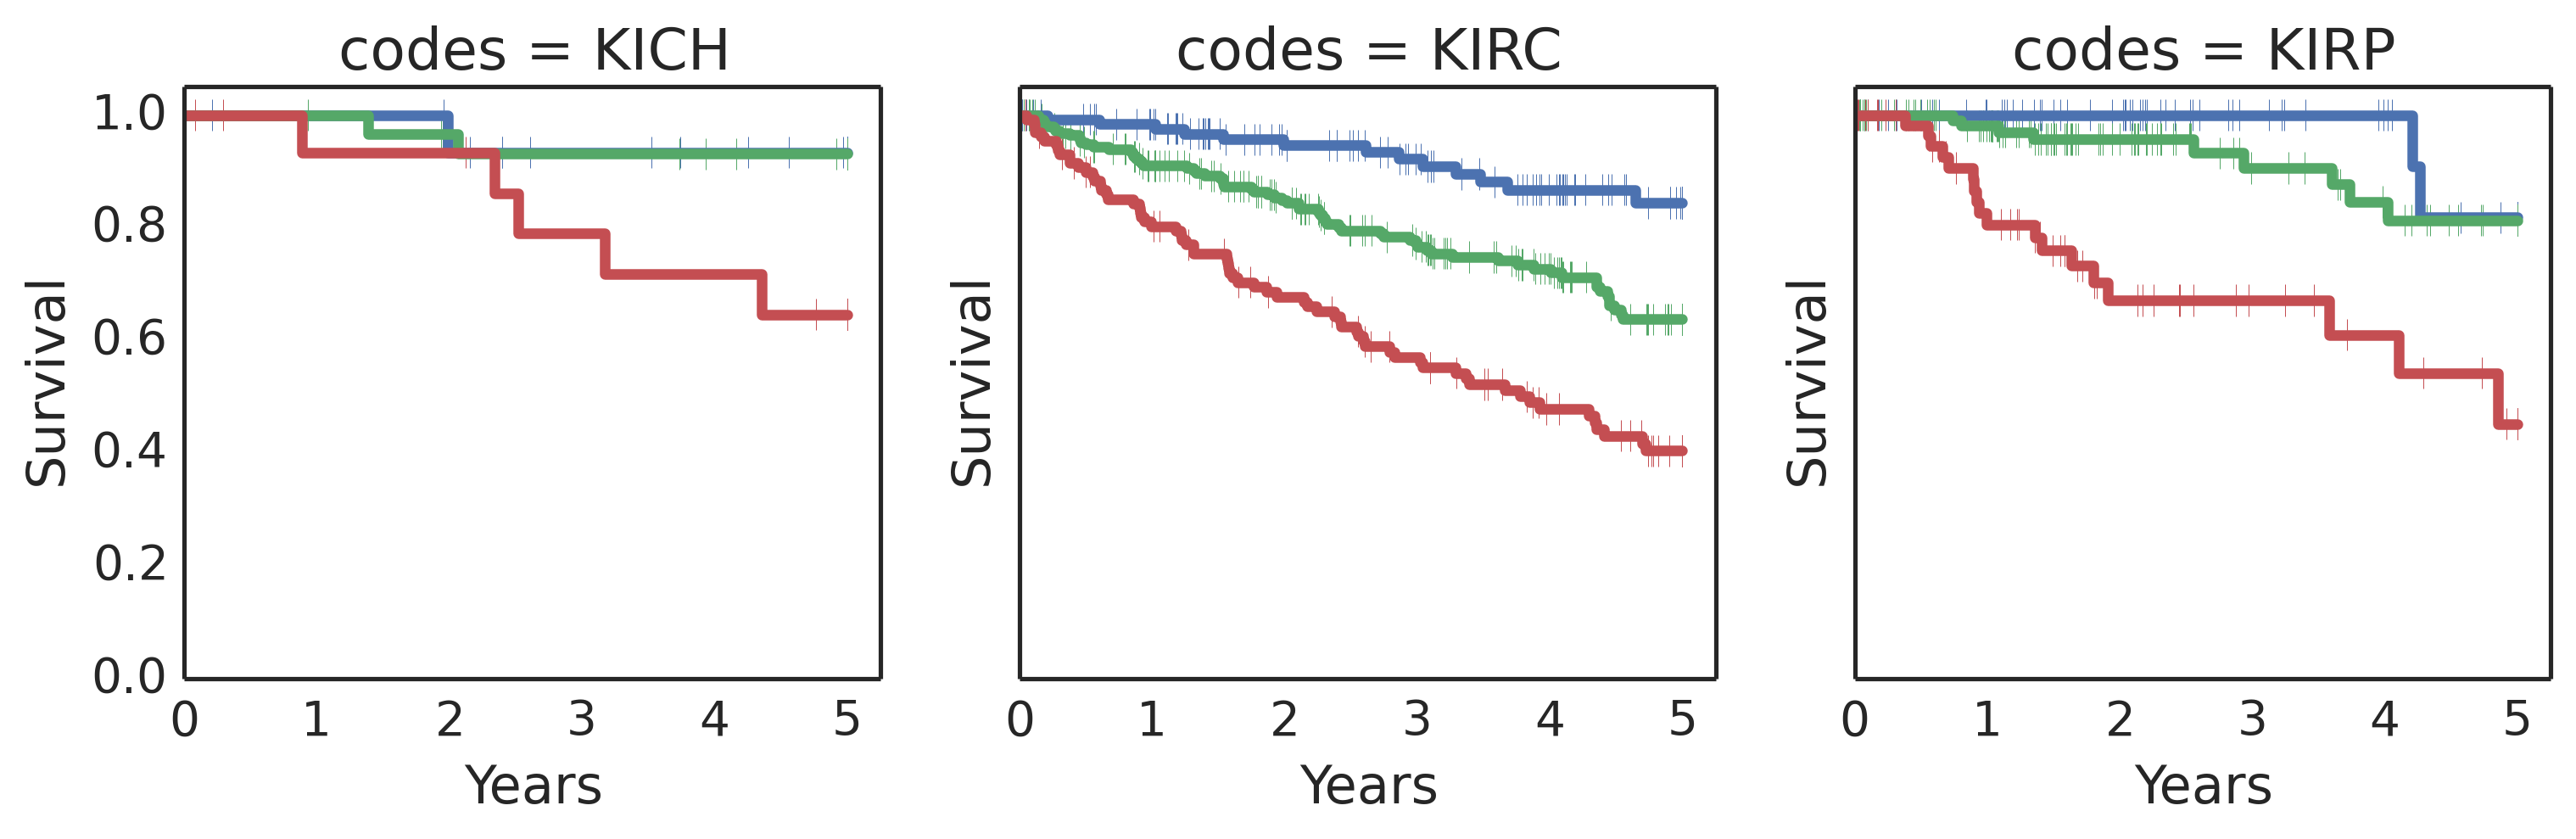

In [46]:
v = rp[:, '01'].dropna()
pts = ti(codes.str.startswith('K'))
draw_survival_curves(v.ix[pts].dropna(), surv_5y, codes.ix[pts].dropna())

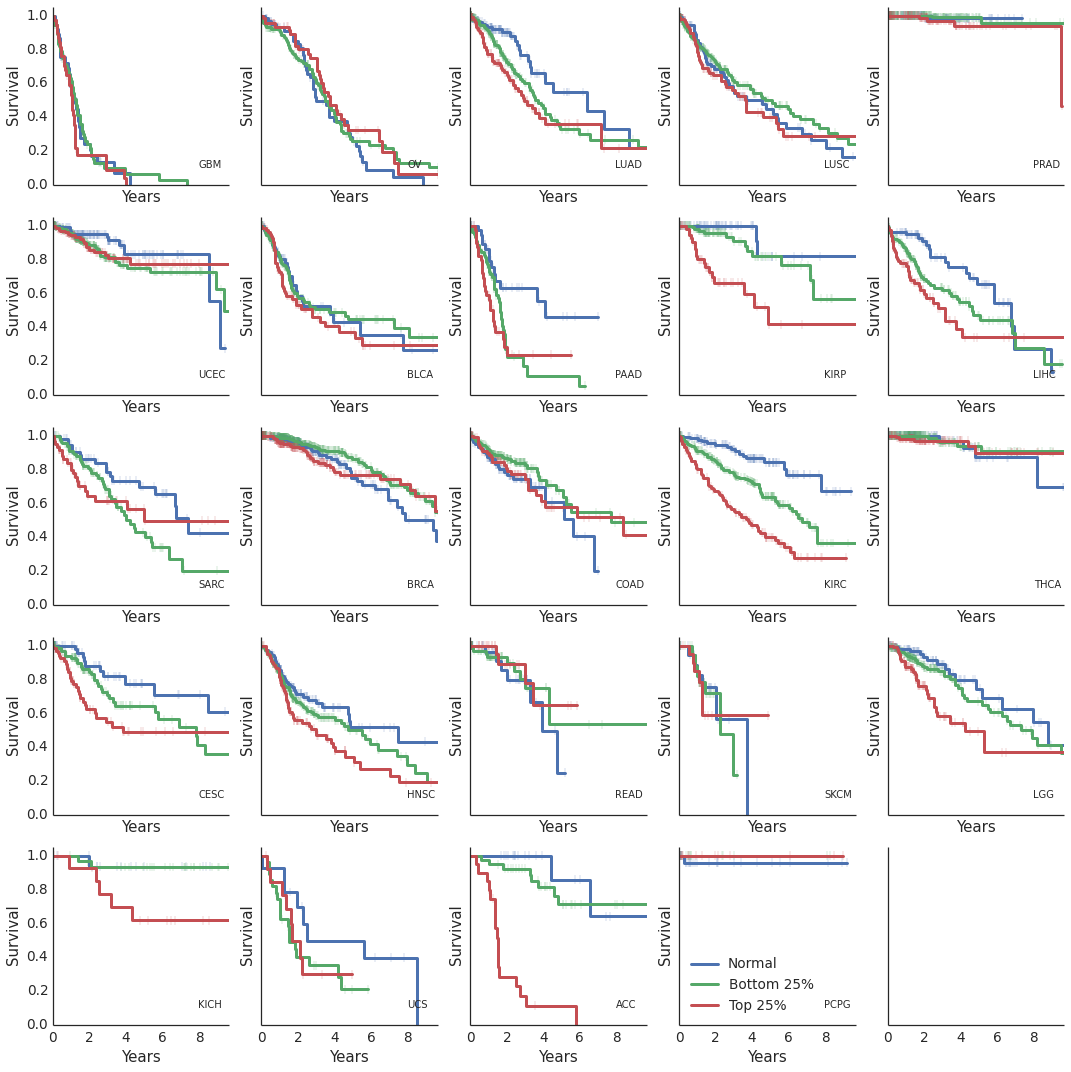

In [119]:
cc = codes.ix[v.index].dropna()
ss = surv_10y.unstack().index
cc = cc[cc.isin(ti(cc.value_counts()  > 30))]
fig, axs = subplots(5,5, figsize=(15,15), sharey=True, sharex=True)
axs = axs.flatten()
for i,c in enumerate(cc.unique()):
    ax = axs[i]
    ax.annotate(c, (8, .1))
    draw_survival_curve(v.ix[ss].ix[ti(cc==c)].dropna(), surv_10y,
                        ax=ax)
    ax.legend_.set_visible(False)
ax.legend_.set_visible(True)
fig.tight_layout()
DX.sns.despine(fig)

In [120]:
v = rp.ix[:, '01'].dropna()
v = v - codes.map(v.groupby(codes).median())
v = v.dropna()
v.name = 'f'

In [121]:
get_cox_ph_ms(surv_5y, v, [codes, stage, old], interactions=False)

LR                                                    1.86e-23
feature_p                                                    0
fmla         Surv(days, event) ~ feature + codes + stage + ...
hazzard                                                   19.6
dtype: object

In [122]:
get_cox_ph_ms(surv_5y, v, [codes, old], interactions=False)

LR                                                    6.33e-34
feature_p                                                    0
fmla         Surv(days, event) ~ feature + codes + age_over...
hazzard                                                   36.4
dtype: object

In [123]:
get_cox_ph_ms(surv_5y, v.ix[keepers], [codes, stage, old, age], interactions=False)

LR                                                    4.45e-17
feature_p                                             2.22e-16
fmla         Surv(days, event) ~ feature + codes + stage + ...
hazzard                                                   17.5
dtype: object